In [1]:
import torch
import math

In [2]:
class TableScene:
    def __init__(self) -> None:
        self.table_length = 1.4
        self.table_width = 2.1
class Env:
    def __init__(self):
        self.goal_radius = 0.1
        self.cube_half_size = 0.02
        self.table_scene = TableScene()

In [112]:
class Grid:
    def __init__(self, cell_size: float = 0.1):
        self.cell_size = cell_size
    
    def compute(self, length: int, width: int):
        self.raw_length = length
        self.raw_width = width
        self.nb_grid_rows = int(self.raw_length // self.cell_size)
        self.nb_grid_cols = int(self.raw_width // self.cell_size)
        
        cols_idx = torch.arange(0, self.nb_grid_cols)
        rows_idx = torch.arange(0, self.nb_grid_rows)

        grid_cell_cols, grid_cell_rows = torch.meshgrid(cols_idx, rows_idx)

        all_cell_indices_col = grid_cell_cols.flatten()
        all_cell_indices_row = grid_cell_rows.flatten()

        self.cells_indices = torch.stack((all_cell_indices_col, all_cell_indices_row), dim=1)

        center_x_coords = (self.cells_indices[:, 0] * self.cell_size) + (self.cell_size / 2.0)
        center_y_coords = (self.cells_indices[:, 1] * self.cell_size) + (self.cell_size / 2.0)
        self.cells_center_xy = torch.stack((center_x_coords, center_y_coords), dim=1)
    
    def compute_max_nb_cells(self, object_bounding_box_extents: torch.Tensor) -> torch.Tensor:
        """
        Computes the number of cells spanned by the largest dimension (width or height)
        found across all object bounding boxes provided.

        Args:
            object_bounding_box_extents: A tensor of shape (nb_obj, >=2) where the first two columns
                                         are [Width, Height] in world units.

        Returns:
            The maximum number of cells spanned by the largest object dimension found.
            E.g., if max dimension is 0.2 and cell_size is 0.1, returns 2.
        """
        object_extents_2d = object_bounding_box_extents[:, :2]
        
        max_overall_dimension = torch.max(object_extents_2d)

        nb_cells_spanned = torch.ceil(max_overall_dimension / self.cell_size)

        return nb_cells_spanned.int()

In [113]:
grid = Grid(cell_size=0.1)
self = Env()

In [114]:
grid.compute(
    length=self.table_scene.table_length,
    width=self.table_scene.table_width
)

In [115]:
grid.cells_indices.shape, grid.cells_indices

(torch.Size([260, 2]),
 tensor([[ 0,  0],
         [ 0,  1],
         [ 0,  2],
         [ 0,  3],
         [ 0,  4],
         [ 0,  5],
         [ 0,  6],
         [ 0,  7],
         [ 0,  8],
         [ 0,  9],
         [ 0, 10],
         [ 0, 11],
         [ 0, 12],
         [ 1,  0],
         [ 1,  1],
         [ 1,  2],
         [ 1,  3],
         [ 1,  4],
         [ 1,  5],
         [ 1,  6],
         [ 1,  7],
         [ 1,  8],
         [ 1,  9],
         [ 1, 10],
         [ 1, 11],
         [ 1, 12],
         [ 2,  0],
         [ 2,  1],
         [ 2,  2],
         [ 2,  3],
         [ 2,  4],
         [ 2,  5],
         [ 2,  6],
         [ 2,  7],
         [ 2,  8],
         [ 2,  9],
         [ 2, 10],
         [ 2, 11],
         [ 2, 12],
         [ 3,  0],
         [ 3,  1],
         [ 3,  2],
         [ 3,  3],
         [ 3,  4],
         [ 3,  5],
         [ 3,  6],
         [ 3,  7],
         [ 3,  8],
         [ 3,  9],
         [ 3, 10],
         [ 3, 11],
        

In [116]:
grid.cells_center_xy.shape, grid.cells_center_xy

(torch.Size([260, 2]),
 tensor([[0.0500, 0.0500],
         [0.0500, 0.1500],
         [0.0500, 0.2500],
         [0.0500, 0.3500],
         [0.0500, 0.4500],
         [0.0500, 0.5500],
         [0.0500, 0.6500],
         [0.0500, 0.7500],
         [0.0500, 0.8500],
         [0.0500, 0.9500],
         [0.0500, 1.0500],
         [0.0500, 1.1500],
         [0.0500, 1.2500],
         [0.1500, 0.0500],
         [0.1500, 0.1500],
         [0.1500, 0.2500],
         [0.1500, 0.3500],
         [0.1500, 0.4500],
         [0.1500, 0.5500],
         [0.1500, 0.6500],
         [0.1500, 0.7500],
         [0.1500, 0.8500],
         [0.1500, 0.9500],
         [0.1500, 1.0500],
         [0.1500, 1.1500],
         [0.1500, 1.2500],
         [0.2500, 0.0500],
         [0.2500, 0.1500],
         [0.2500, 0.2500],
         [0.2500, 0.3500],
         [0.2500, 0.4500],
         [0.2500, 0.5500],
         [0.2500, 0.6500],
         [0.2500, 0.7500],
         [0.2500, 0.8500],
         [0.2500, 0.9500],
     

In [117]:
grid.nb_grid_cols, grid.nb_grid_rows

(20, 13)

In [118]:
class SafePath:
    def __init__(self, grid: Grid, nb_buffer_cells: int = 2, epsilon: float = 1e-6):
        self.nb_buffer_cells = nb_buffer_cells
        self.grid = grid
        self.epsilon = epsilon
    
    def compute(self, center_points_to_secure: torch.Tensor):
        """
        center_points_to_secure: (nb_points, 2) in x,y format
        """
        nb_points = center_points_to_secure.shape[0]
        assert nb_points > 0, "No points to secure!"
        
        if nb_points == 1:
            safe_path_cells_mask = self._compute_circle_cells_mask(center_points_to_secure)
            print(f"safe_path_cells_mask.shape: {safe_path_cells_mask.shape}")
        else:
            safe_path_cells_mask = torch.zeros((self.grid.nb_grid_cols * self.grid.nb_grid_rows), dtype=torch.bool, device=center_points_to_secure.device)
            for i in range(nb_points - 1):
                p_start = center_points_to_secure[i]
                p_end = center_points_to_secure[i+1]
                cells_mask = self._compute_capsule_segment_cells_mask(p_start, p_end)
                print(f"p_start: {p_start}, p_end: {p_end}, cells_mask: {cells_mask}")
                print(f"cells_mask.sum(): {cells_mask.sum()}")
                print(f"BEFORE safe_path_cells_mask.sum(): {safe_path_cells_mask.sum()}")
                safe_path_cells_mask = torch.logical_or(safe_path_cells_mask, cells_mask)
                print(f"AFTER safe_path_cells_mask.sum(): {safe_path_cells_mask.sum()}")
                
        
            print(f"safe_path_cells_mask: {safe_path_cells_mask}")
        
        return self.grid.cells_indices[safe_path_cells_mask]
    
    def _compute_circle_cells_mask(self, point_xy: torch.Tensor) -> torch.Tensor:
        dist_to_point = torch.norm(self.grid.cells_center_xy - point_xy, dim=1)
        distance_buffer = self.nb_buffer_cells * self.grid.cell_size + self.epsilon
        cells_mask = dist_to_point <= distance_buffer
        return cells_mask
    
    def _compute_capsule_segment_cells_mask(
        self, 
        p_start_xy: torch.Tensor,
        p_end_xy: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes a boolean mask that has True for all the cells that are inside the capsule that is formed by p_start_xy and p_end_xy given a safety buffer.
        
        First we compute a segment (line) S between the p_start_xy and p_end_xy.
        Then we compute a buffer zone (cells), this essentially represents the number of cells we allow on each side of the segment (but we store the total buffer length of the cells instead of number of cells). 
        
        Then we compute a vector V_sc that represents a line between p_start_xy and each of the grid cells center.
        We compute the projection of this V_sc vector onto the segment vector S.
        Then we compute the point p_proj on S where the orthogonal projection of V_sc on S arrives.
        We compute the distance between the point p_proj and the cell center and check if the distance is within the corridor buffer length.
            If so, then it means the cell should be considered a "safe cell", otherwise it means it is too far and should not be considered a "safe cell".
        
        Finally we compute the boolean masks for the capsule body, capsule cap start, capsule cap end by only taking the cells that are within the corridor buffer length for at least one part of the capsule (either the start cap, body or end cap).
        o===o
        ^ ^ ^
        | | end cap
        | body
        start cap   
        
        Returns:
            1D vector representing if true/false we should treat the cell index ij as safe or not. 
        """
        segment_vector = p_end_xy - p_start_xy
        segment_length = torch.norm(segment_vector)
        corridor_buffer_length = self.nb_buffer_cells * self.grid.cell_size + self.epsilon
        
        are_the_points_too_close = segment_length.item() < self.epsilon
        if are_the_points_too_close:
            return self._compute_circle_cells_mask(p_start_xy)
        
        start_to_cell_center_vectors = self.grid.cells_center_xy - p_start_xy.unsqueeze(0)
        segment_length_squared = segment_length.pow(2)
        start_to_cell_center_projection_on_segment = torch.sum(start_to_cell_center_vectors * segment_vector.unsqueeze(0), dim=1) / segment_length_squared
        closest_point_on_segment_to_cell_center = p_start_xy.unsqueeze(0) + start_to_cell_center_projection_on_segment.unsqueeze(1) * segment_vector.unsqueeze(0)
        
        distance_between_cell_center_and_segment = torch.norm(self.grid.cells_center_xy - closest_point_on_segment_to_cell_center, dim=1)
        mask_perp_dist_ok = distance_between_cell_center_and_segment <= corridor_buffer_length
        
        projection_on_or_after_start = (start_to_cell_center_projection_on_segment >= 0)
        projection_on_or_before_end = (start_to_cell_center_projection_on_segment <= 1)
        capsule_body_cells_mask = torch.logical_and(torch.logical_and(projection_on_or_after_start, projection_on_or_before_end), mask_perp_dist_ok)
        
        distance_between_cell_center_and_p_start = torch.norm(self.grid.cells_center_xy - p_start_xy.unsqueeze(0), dim=1)
        is_cell_center_before_p_start = start_to_cell_center_projection_on_segment < 0
        capsule_cap_p_start_cells_mask = torch.logical_and(is_cell_center_before_p_start, distance_between_cell_center_and_p_start <= corridor_buffer_length)
        
        distance_between_cell_center_and_p_end = torch.norm(self.grid.cells_center_xy - p_end_xy.unsqueeze(0), dim=1)
        is_cell_center_after_p_end = start_to_cell_center_projection_on_segment > 1
        capsule_cap_p_end_cells_mask = torch.logical_and(is_cell_center_after_p_end, distance_between_cell_center_and_p_end <= corridor_buffer_length)
        
        total_capsule_cells_mask = capsule_body_cells_mask | capsule_cap_p_start_cells_mask | capsule_cap_p_end_cells_mask
        return total_capsule_cells_mask

In [119]:
table_top_center_world_xy = torch.tensor([self.table_scene.table_width / 2, 0.0])
cube_center_world_xy = torch.tensor([0.75, 0.35]) #self.cube_manipulation_object.pose.p[..., :2]
goal_center_world_xy = torch.tensor([1.5, 0.9]) #self.goal_region.pose.p[..., :2]

center_points_to_secure = torch.stack([table_top_center_world_xy, cube_center_world_xy, goal_center_world_xy])

In [121]:
grid.compute_max_nb_cells(object_bounding_box_extents=torch.tensor([
    [0.1, 0.1],
    [0.05, 0.05],
    [0.25, 0.2]
]))

tensor(3, dtype=torch.int32)

In [122]:
safe_path = SafePath(
    grid=grid,
    nb_buffer_cells=3,
    epsilon=1e-6
)

In [123]:

safe_path_cell_indices = safe_path.compute(center_points_to_secure=center_points_to_secure)

p_start: tensor([1.0500, 0.0000]), p_end: tensor([0.7500, 0.3500]), cells_mask: tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False,  True

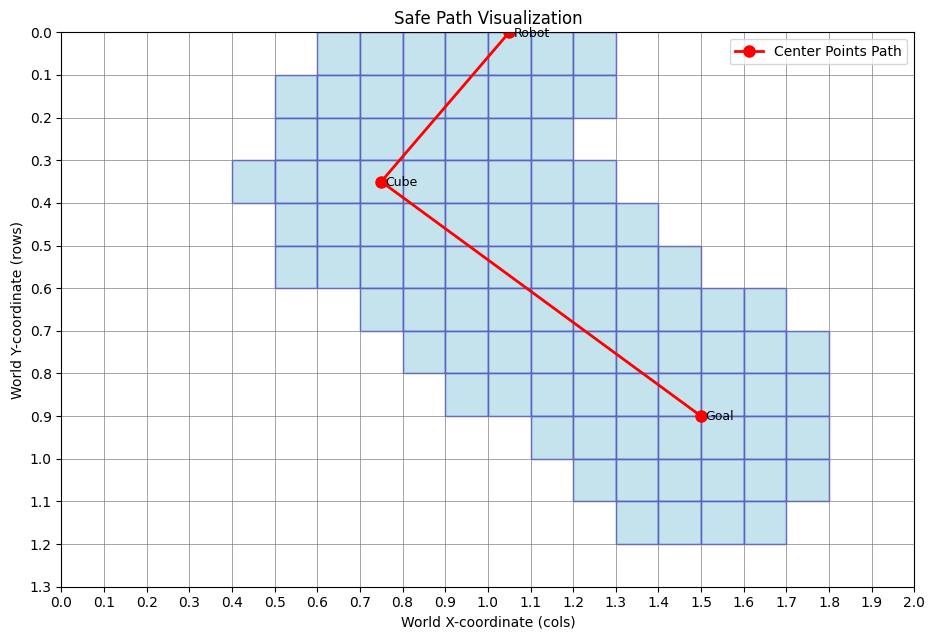


Found 96 safe cells. First 5:
[[4 3]
 [5 1]
 [5 2]
 [5 3]
 [5 4]]


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

def visualize_safe_path(
    grid_obj: Grid,
    safe_cell_indices: torch.Tensor,
    center_points_to_secure: torch.Tensor,
    title: str = "Safe Path Visualization"
):
    if grid_obj.nb_grid_cols == 0 or grid_obj.nb_grid_rows == 0:
        print("Cannot visualize an empty grid.")
        return

    world_width = grid_obj.nb_grid_cols * grid_obj.cell_size
    world_height = grid_obj.nb_grid_rows * grid_obj.cell_size

    fig, ax = plt.subplots(figsize=(grid_obj.nb_grid_cols * 0.5, grid_obj.nb_grid_rows * 0.5))
    ax.set_aspect('equal', adjustable='box')

    ax.set_xticks(torch.arange(0, world_width + grid_obj.cell_size, grid_obj.cell_size).numpy())
    ax.set_yticks(torch.arange(0, world_height + grid_obj.cell_size, grid_obj.cell_size).numpy())
    ax.set_xlim(0, world_width)
    ax.set_ylim(0, world_height)
    ax.grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
    
    ax.invert_yaxis()

    safe_cells_np = safe_cell_indices.cpu().numpy()
    for col_idx, row_idx in safe_cells_np:
        rect = Rectangle(
            (col_idx * grid_obj.cell_size, row_idx * grid_obj.cell_size),
            grid_obj.cell_size,
            grid_obj.cell_size,
            facecolor='lightblue',
            alpha=0.7,
            edgecolor='blue'
        )
        ax.add_patch(rect)

    points_np = center_points_to_secure.cpu().numpy()
    ax.plot(points_np[:, 0], points_np[:, 1], 'ro-', label='Center Points Path', markersize=8, linewidth=2) # Red circles connected by lines
    for i, (x, y) in enumerate(points_np):
        if i == 0:
            obj_type = "Robot"
        elif i == 1:
            obj_type = "Cube"
        else:
            obj_type = "Goal"
        ax.text(x + grid_obj.cell_size * 0.1, y + grid_obj.cell_size * 0.1, f"{obj_type}", color='black', fontsize=9)


    ax.set_xlabel("World X-coordinate (cols)")
    ax.set_ylabel("World Y-coordinate (rows)")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

visualize_safe_path(
    grid_obj=grid,
    safe_cell_indices=safe_path_cell_indices,
    center_points_to_secure=center_points_to_secure,
)

print(f"\nFound {safe_path_cell_indices.shape[0]} safe cells. First 5:")
print(safe_path_cell_indices[:5].cpu().numpy())